<a href="https://colab.research.google.com/github/tevfikcagridural/Steel_Defect_Detection/blob/main/Capstone_3_Modelling_With_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Connect to Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pathlib
import shutil


# Copy data from google drive
zip_train = pathlib.Path('/content/drive/MyDrive/severstaal-steel-defect/train_images.zip')
zip_test = pathlib.Path('/content/drive/MyDrive/severstaal-steel-defect/test_images.zip')
zip_train_csv = pathlib.Path('/content/drive/MyDrive/severstaal-steel-defect/train.csv.zip')

dest = pathlib.Path('/content/')

shutil.copy(zip_train, dest)
shutil.copy(zip_test, dest)
shutil.copy(zip_train_csv, dest)


'/content/train.csv.zip'

In [6]:
import zipfile

# Unzip images
zipfile_train = 'train_images.zip'
zipfile_test = 'test_images.zip'

with zipfile.ZipFile(zipfile_train) as ztr:
  ztr.extractall('train_images')

with zipfile.ZipFile(zipfile_test) as zte:
  zte.extractall('test_images')

# Load images

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
# load dataframe
train_csv = pd.read_csv("/content/train.csv.zip", dtype=str)

In [3]:
SEED = 42
BATCH_SIZE = 32
CLASS_MODE = 'categorical'
TARGET_SIZE =  (256, 1600)

In [5]:
train_datagen = ImageDataGenerator(validation_split=0.25)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_csv.iloc[:,:2],
    directory='../content/train_images/',
    x_col = 'ImageId',
    y_col = 'ClassId',
    subset = 'training',
    batch_size = BATCH_SIZE,
    seed = SEED,
    class_mode = CLASS_MODE,
    target_size = TARGET_SIZE
)
valid_generator = train_datagen.flow_from_dataframe(
    dataframe=train_csv.iloc[:,:2],
    directory='../content/train_images/',
    x_col = 'ImageId',
    y_col = 'ClassId',
    subset = 'validation',
    batch_size = BATCH_SIZE,
    seed = SEED,
    class_mode = CLASS_MODE,
    target_size = TARGET_SIZE
)

Found 5322 validated image filenames belonging to 4 classes.
Found 1773 validated image filenames belonging to 4 classes.


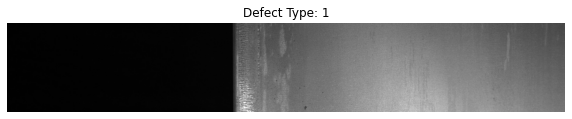

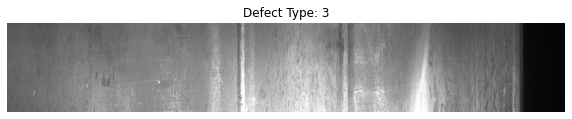

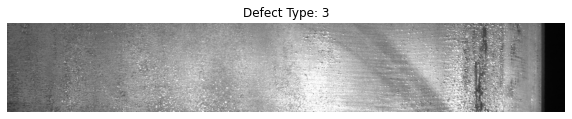

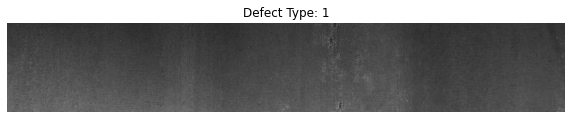

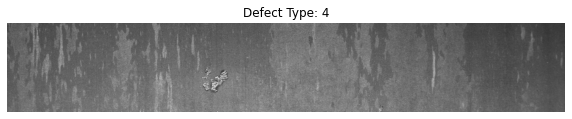

In [106]:
def get_class_string_from_index(index):
   for class_string, class_index in valid_generator.class_indices.items():
      if class_index == index:
         return class_string

for i in range(5):
  x, y = next(train_generator)
  image = x[0, :, :, :] #First image on batch
  true_index = np.argmax(y[0]) #index of ene-hot encoded label 
  plt.figure(figsize=(10,10))
  ax = plt.subplot(5, 1, i+1)
  ax.imshow(image.astype('uint8'))
  ax.axis('off')
  plt.title("Defect Type: " + get_class_string_from_index(true_index))
  plt.show()

# Modelling MobileNetV2

In [7]:
# To rescale the values between [-1,1]
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## TODO: Apply more augmentations 
# Data Augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [8]:
INPUT_SHAPE = TARGET_SIZE + (3, ) 
base_model = tf.keras.applications.MobileNetV2(input_shape=INPUT_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [9]:
image_batch, label_batch = next(iter(train_generator))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 8, 50, 1280)


In [10]:
base_model.trainable = False

In [11]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 1600, 3 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 800, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 800, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 128, 800, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [12]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [13]:
prediction_layer = tf.keras.layers.Dense(4,
                                         kernel_regularizer=tf.keras.regularizers.l2(0.001))
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


In [14]:
inputs = tf.keras.Input(shape=(256, 1600, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [15]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 1600, 3)]    0         
_________________________________________________________________
sequential (Sequential)      (None, 256, 1600, 3)      0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 256, 1600, 3)      0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 256, 1600, 3)      0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 8, 50, 1280)       2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [17]:
len(model.trainable_variables)

2

In [18]:
initial_epochs = 5

loss0, accuracy0 = model.evaluate(valid_generator)

56/56 [==============================] - 28s 456ms/step - loss: 2.0210 - accuracy: 0.1119


In [19]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.02
initial accuracy: 0.11


In [20]:
history = model.fit(train_generator,
                    epochs=initial_epochs,
                    validation_data=valid_generator)

Epoch 1/5
166/166 [==============================] - 97s 572ms/step - loss: 1.1734 - accuracy: 0.6009 - val_loss: 0.9749 - val_accuracy: 0.7148
Epoch 2/5
166/166 [==============================] - 93s 558ms/step - loss: 0.9596 - accuracy: 0.7098 - val_loss: 0.9181 - val_accuracy: 0.7182
Epoch 3/5
166/166 [==============================] - 93s 558ms/step - loss: 0.9045 - accuracy: 0.7206 - val_loss: 0.8810 - val_accuracy: 0.7256
Epoch 4/5
166/166 [==============================] - 93s 557ms/step - loss: 0.8727 - accuracy: 0.7408 - val_loss: 0.8520 - val_accuracy: 0.7330
Epoch 5/5
166/166 [==============================] - 93s 557ms/step - loss: 0.8572 - accuracy: 0.7353 - val_loss: 0.8436 - val_accuracy: 0.7273


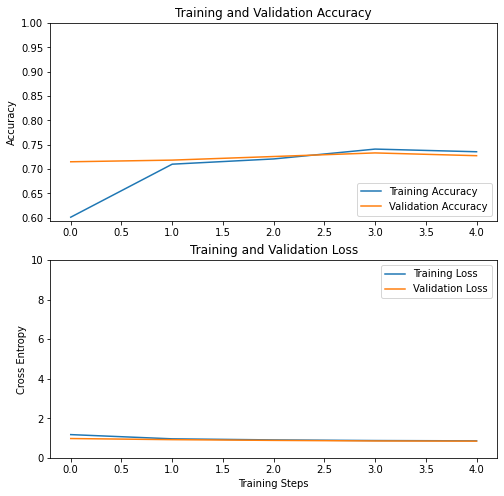

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,10])
plt.title('Training and Validation Loss')
plt.xlabel('epochs')
plt.show()


## Fine tuning

In [62]:
base_model.trainable = True

In [63]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [64]:
fine_tune_at = 140

In [65]:
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [66]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
              optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [67]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 1600, 3)]    0         
_________________________________________________________________
sequential (Sequential)      (None, 256, 1600, 3)      0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 256, 1600, 3)      0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 256, 1600, 3)      0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 8, 50, 1280)       2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [68]:
len(model.trainable_variables)

17

In [69]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_generator,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=valid_generator)

Epoch 5/15
166/166 [==============================] - 97s 565ms/step - loss: 0.8097 - accuracy: 0.7536 - val_loss: 0.7889 - val_accuracy: 0.7477
Epoch 6/15
166/166 [==============================] - 96s 577ms/step - loss: 0.7375 - accuracy: 0.7936 - val_loss: 0.7712 - val_accuracy: 0.7489
Epoch 7/15
166/166 [==============================] - 96s 576ms/step - loss: 0.7245 - accuracy: 0.7915 - val_loss: 0.7555 - val_accuracy: 0.7648
Epoch 8/15
166/166 [==============================] - 95s 570ms/step - loss: 0.7052 - accuracy: 0.8176 - val_loss: 0.7363 - val_accuracy: 0.7795
Epoch 9/15
166/166 [==============================] - 95s 572ms/step - loss: 0.7084 - accuracy: 0.8115 - val_loss: 0.7326 - val_accuracy: 0.7778
Epoch 10/15
166/166 [==============================] - 96s 577ms/step - loss: 0.6950 - accuracy: 0.8103 - val_loss: 0.7445 - val_accuracy: 0.7682
Epoch 11/15
166/166 [==============================] - 96s 579ms/step - loss: 0.6911 - accuracy: 0.8202 - val_loss: 0.7082 - val_

In [47]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


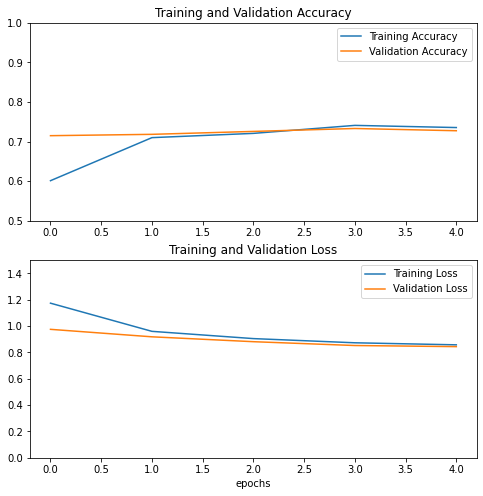

In [79]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
# plt.plot([initial_epochs-1,initial_epochs-1],
#           plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.5])
# plt.plot([initial_epochs-1,initial_epochs-1],
#          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epochs')
plt.show()


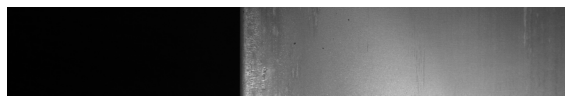

True label: 1
Predicted label: 1


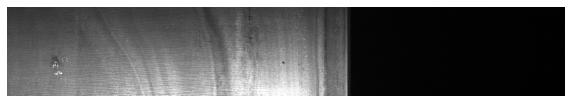

True label: 3
Predicted label: 3


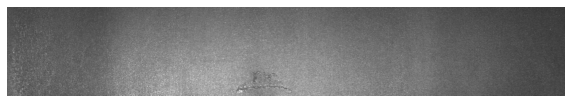

True label: 3
Predicted label: 3


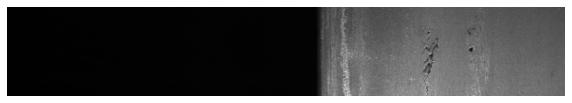

True label: 3
Predicted label: 3


In [96]:
for i in range(4):
  x, y = next(valid_generator)
  image = x[0, :, :, :]
  true_index = np.argmax(y[0])
  plt.figure(figsize=(10,10))
  ax = plt.subplot(5, 1, i+1)
  ax.imshow(image.astype('uint8'))
  ax.axis('off')
  plt.show()


  prediction_scores = model.predict(np.expand_dims(image, axis=0))
  predicted_index = np.argmax(prediction_scores)
  print("True label: " + get_class_string_from_index(true_index))
  print("Predicted label: " + get_class_string_from_index(predicted_index))
